# P켓몬 데이터 뭉치에서 전설의 P켓몬을 골라낼 수 있을까?

### Ch.2 일반 P켓몬으로부터 전설의 P켓몬을 분류하는 모델 학습시키기

### 학습 목표
- 데이터를 머신러닝에 필요한 형태로 전처리하는 방법을 배운다.
- 

---

# Contents
#### 1. 데이터 전처리하기
#### 2. EDA #1: 모든 컬럼 뜯어보기
#### 3. EDA #2: Legendary / Ordinary P켓몬 비교하기

---

시작하기 위해 필요한 모듈과 데이터를 준비하겠습니다.

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [29]:
original_data = pd.read_csv("pkemon.csv")
pkemon = original_data.copy()

---

# 1. 데이터 전처리하기

지금까지의 EDA를 바탕으로, 모델에 데이터를 돌리기 위해 다음과 같은 세 가지 전처리를 해야 합니다.

- **`Name`** : 문자열 데이터를 EDA 결과에 따라 적절히 처리하기

        
- **`Type 1` & `Type 2`** : 무슨 Type를 가지냐에 따라 categorical 데이터로 변환하기
    


### (1) `Name` : 이름

앞서 확인한 EDA 과정에서 이름은 전설의 P켓몬인지 아닌지를 결정하는 중요한 특징 중 하나였죠.    
따라서 이름에 관해서는 두 가지를 중점적으로 처리해 보겠습니다.
      
**1. 이름의 길이** : `name_count` 컬럼을 생성 후 길이가 10을 넘는지 아닌지에 대한 categorical 컬럼을 생성
    
    
**2. 토큰 추출** : legendary 포켓몬에서 많이 등장하는 토큰을 추려내고 토큰 포함 여부를 one-hot-encoding으로 처리

#### 이름의 길이

이름의 길이를 확인할 수 있는 `name_count` 컬럼을 생성합니다.

In [30]:
pkemon["name_count"] = pkemon["Name"].apply(lambda i: len(i))
pkemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


또한 이름의 길이가 10 이상이면 True, 미만이면 False을 가지는 `long_name` 컬럼을 생성합니다.

In [31]:
pkemon["long_name"] = pkemon["name_count"] >= 10
pkemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


다만, 전설의 포켓몬을 분류하는 데에는 이름의 길이값 자체를 갖고 있는 `name_count` 컬럼이 더 유리할지, 혹은 `long_name`이 더 유리할지는 아직 모릅니다.


따라서 모델을 학습 시킬 때에는 두 가지를 모두 활용해 볼 것입니다.

#### 토큰 추출

토큰을 추출하기에 앞서, 포켓몬의 이름에 대해 먼저 알아보겠습니다.  


포켓몬의 이름은 총 네 가지 타입으로 나뉩니다.
   - 한 단어인 경우 `ex. Venusaur`
   - 두 단어이고, 앞 단어는 두 개의 대문자를 가지며 대문자를 기준으로 두 부분으로 나뉘는 경우 `ex. VenusaurMega Venusaur`
   - 이름은 두 단어이고, 맨 뒤에 X, Y로 성별을 표시하는 경우 `ex. CharizardMega Charizard X`
   - 알파벳이 아닌 문자를 포함하는 경우 `ex. Zygarde50% Forme`

이 중 가장 먼저 알파벳이 아닌 문자를 포함하는 경우를 처리하도록 하겠습니다.     
어떤 문자열이 알파벳으로만 이루어져있는지를 확인하고 싶을 때는 `isalpha()` 함수를 사용하면 편리합니다. 

우리는 알파벳이 아닌 문자를 포함하는 이름을 걸러내고 싶은데, 주의할 점은 이름에 띄어쓰기가 있는 경우에도 `isalpha() = False`로 처리된다는 점입니다.    
따라서 알파벳 체크를 위한 띄어쓰기가 없는 컬럼을 따로 만들어준 후, 띄어쓰기를 빈칸으로 처리해서 확인하도록 하겠습니다.

In [32]:
pkemon["Name_nospace"] = pkemon["Name"].apply(lambda i: i.replace(" ", ""))
pkemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7,False,Diancie
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19,True,DiancieMegaDiancie
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19,True,HoopaHoopaConfined
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18,True,HoopaHoopaUnbound
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9,False,Volcanion


모든 띄어쓰기가 없어진 것이 확인되는군요.     


이제 `isalpha()` 함수를 이용해 이름이 알파벳으로만 이루어졌는지를 확인해봅시다.

In [33]:
pkemon["name_isalpha"] = pkemon["Name_nospace"].apply(lambda i: i.isalpha())
pkemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False,Bulbasaur,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False,Ivysaur,True
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False,Venusaur,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True,VenusaurMegaVenusaur,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True,Charmander,True


`name_isalpha` 컬럼이 잘 생성된 것으로 보입니다. 그렇다면 알파벳이  아닌 다른 문자가 이름에 포함된 것은 어떤 것들이 있을까요?

In [34]:
print(pkemon[pkemon["name_isalpha"] == False].shape)
pkemon[pkemon["name_isalpha"] == False]

(9, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran♀,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran♂,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetch'd,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon2,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho-oh,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon-Z,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


이름에 알파벳이 아닌 것을 포함하는 경우는 9마리 뿐이군요.    


이 정도면 직접 이름을 바꿔줄 수 있겠습니다. 적당히 합리적으로 바꿔주도록 하겠습니다.    
문자열을 원하는 다른 문자열로 바꾸고 싶을 때에는 pandas의 `replace` 함수를 사용하면 됩니다.

In [35]:
# 직접 9개의 row를 위의 세 가지 타입에 각각 들어갈 수 있도록 변환
pkemon = pkemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pkemon = pkemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pkemon = pkemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pkemon = pkemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pkemon = pkemon.replace(to_replace="Porygon2", value="Porygon")
pkemon = pkemon.replace(to_replace="Ho-oh", value="Ho Oh")
pkemon = pkemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pkemon = pkemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pkemon = pkemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pkemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


다시 `isalpha`로 확인해볼까요?    


바꿔준 `Name` 컬럼으로 `Name_nospace`를 만들고, 다시ㅣ `isalpha`로 체크를 해보겠습니다.

In [36]:
pkemon["Name_nospace"] = pkemon["Name"].apply(lambda i: i.replace(" ", ""))
pkemon["name_isalpha"] = pkemon["Name_nospace"].apply(lambda i: i.isalpha())
pkemon[pkemon["name_isalpha"] == False]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha


name_isalpha 컬럼이 False인 컬럼이 하나도 없군요. 모든 이름이 알파벳으로만 이루어졌음을 뜻하는 것이죠!     

그러면 이제 모든 이름은 세 가지 타입으로 나뉘므로 토크나이징할 수 있습니다.  
이름에 있는 토큰을 추출하기 위해 이름을 토크나이징 (모든 토큰으로 분리) 할 수 있는 함수를 생성해 주겠습니다.

In [43]:
def tokenize(name):
    # 먼저 이름을 " " 기준으로 split
    tokens = name.split(" ")
    
    # 포켓몬의 이름이 한 단어가 아니라면 첫 번째 이름은 항상 대문자 두 개로 이루어져있으므로, 대문자를 기준으로 분리한다.
    # 분리는 re 패키지의 findall() 함수를 이용한다.
    if len(tokens) != 1:
        a = re.findall('[A-Z][a-z]*', tokens[0])
        tokens = a + tokens[1:]
        
    return tokens

In [44]:
# 실험해보자
name = "CharizardMega Charizard X"
tokenize(name)

['Charizard', 'Mega', 'Charizard', 'X']

대문자를 기준으로 모든 토큰이 분리됨을 확인할 수 있다!

이제 전설의 포켓몬에게 가장 많이 쓰이는 토큰을 찾아내보자.

In [45]:
# train 내의 모든 토큰을 모아보자
all_tokens = list(train["Name"].apply(tokenize).values)

token_set = []
for i in all_tokens:
    for token in i:
        token_set.append(token)

len(set(token_set))

763

총 763개의 토큰을 가지는 token_set이 만들어졌다. 여기서 여러번 사용된 토큰을 추출해보자.

In [46]:
# collections 모듈의 Counter 함수로 상위 30개 토큰을 추출한다.
train_mostcommon = collections.Counter(token_set).most_common(10)
print(train_mostcommon[:5], len(train_mostcommon))

[('Mega', 48), ('Forme', 21), ('Rotom', 11), ('Size', 8), ('Charizard', 5)] 10


같은 방법으로 legendary pokemon에 대해서도 토큰을 추출해보자.

In [47]:
# legendary 내의 모든 토큰을 모아보자
all_tokens_leg = list(legendary["Name"].apply(tokenize).values)

token_set_leg = []
for i in all_tokens_leg:
    for token in i:
        token_set_leg.append(token)

len(set(token_set_leg))

65

In [48]:
# collections 모듈의 Counter 함수로 상위 20개 토큰을 추출한다. (2번 이상 사용된 토큰)
leg_mostcommon = collections.Counter(token_set_leg).most_common(20)
print(leg_mostcommon[:5], len(leg_mostcommon))

[('Forme', 15), ('Mega', 6), ('Mewtwo', 5), ('Kyurem', 5), ('Deoxys', 4)] 20


이제 train과 legendary에서 둘 다 많이 쓰인 토큰을 추려보자.

In [49]:
all_mostcommon = []
for i, j in zip(train_mostcommon, leg_mostcommon):
    all_mostcommon.append(i[0])
    all_mostcommon.append(j[0])
    
all_mostcommon = list(set(all_mostcommon))
print(all_mostcommon, len(all_mostcommon))

['Size', 'Pumpkaboo', 'Gourgeist', 'Kyogre', 'Kyurem', 'Forme', 'Charizard', 'Latias', 'Hoopa', 'Groudon', 'Deoxys', 'Latios', 'Mega', 'Mewtwo', 'Rotom'] 15


이렇게 해서 가장 의미있는 토큰 15가지를 추려냈다. 이 토큰들을 one-hot-encoding으로 컬럼을 추가하자!!

In [50]:
# train 데이터에 mostcommon 토큰을 one hot encoding 하자
for token in all_mostcommon:
    train[token] = train["Name"].str.contains(token)

train[[["Name"] + all_mostcommon][0]][:10]

,Name,Size,Pumpkaboo,Gourgeist,Kyogre,Kyurem,Forme,Charizard,Latias,Hoopa,Groudon,Deoxys,Latios,Mega,Mewtwo,Rotom
0,Bulbasaur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Ivysaur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Venusaur,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,VenusaurMega Venusaur,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,Charmander,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,Charmeleon,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,Charizard,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7,CharizardMega Charizard X,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
8,CharizardMega Charizard Y,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
9,Squirtle,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


`Charizard`를 포함한 7, 8, 9번 포켓몬의 "Charizard" 컬럼이 True임을 확인할 수 있다.

---

## PreProcessing#2 `Type 1` & `Type 2`

Type은 한 가지 속성을 가지느냐, 두 가지를 가지느냐에 따라 NaN값이 있을 수도 없을 수도 있다.
   - 따라서 18가지의 모든 type를 모두 one-hot-encoding 한다.
   - 두 가지 속성을 가진 포켓몬은 두 가지 type에 대해서 1 값을 가지도록 한다.

In [51]:
# 모든 type 리스트
print(types)

['Poison', 'Electric', 'Dark', 'Water', 'Fighting', 'Flying', 'Ice', 'Ghost', 'Ground', 'Grass', 'Steel', 'Psychic', 'Rock', 'Fairy', 'Bug', 'Fire', 'Dragon', 'Normal']


In [52]:
for type_ in types:
    train[type_] = (train["Type 1"] == type_) | (train["Type 2"] == type_)
    
train[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Poison,Electric,Dark,Water,Fighting,Flying,Ice,Ghost,Ground,Grass,Steel,Psychic,Rock,Fairy,Bug,Fire,Dragon,Normal
0,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,Grass,Poison,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,Fire,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


Type별로 one-hot-encoding이 잘 됐음을 확인할 수 있다.

---

## PreProcessing#3 stats

Total과 6가지의 스탯은 서로 선형 종속의 관계를 가지므로 한 가지 컬럼을 제거해야한다. 
   - EDA에서의 결론에 따라 Total 컬럼을 삭제하는 대신, 가장 특징을 갖지 않는 컬럼을 삭제한다.
   - 6가지 스탯 중 가장 평이하게 Total값과 높은 상관관계를 가지는 컬럼을 찾아 삭제하는 것으로 한다.

In [53]:
# 관련성을 가지는 컬럼
linearity = ["Total", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]

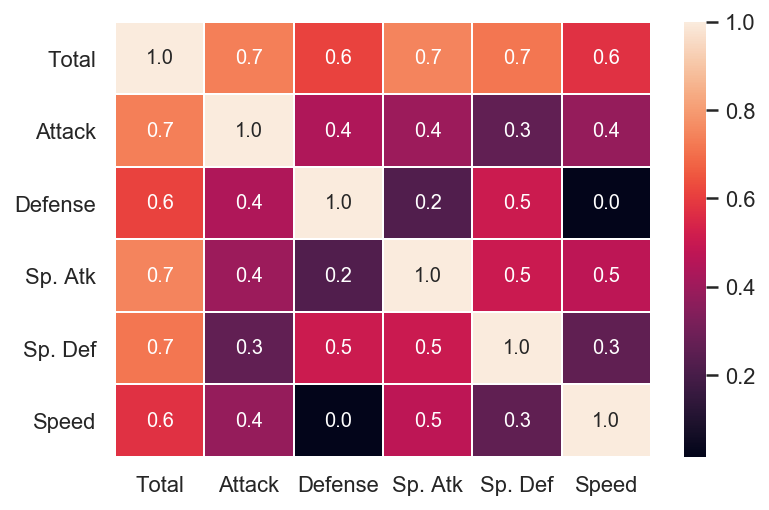

In [54]:
corr = train[linearity].corr()
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr, annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

Total과 나머지 속성은 각각 (0.7, 0.6, 0.7, 0.7, 0.6)의 상관관계를 가진다.  
이 중 Attack을 제외하기로 한다.

---

# Fit & Predict

먼저 사용해야 할 컬럼을 추려내자.

In [55]:
print(train.columns, len(train.columns))

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'name_count',
       'long_name', 'name_isalpha', 'Size', 'Pumpkaboo', 'Gourgeist', 'Kyogre',
       'Kyurem', 'Forme', 'Charizard', 'Latias', 'Hoopa', 'Groudon', 'Deoxys',
       'Latios', 'Mega', 'Mewtwo', 'Rotom', 'Poison', 'Electric', 'Dark',
       'Water', 'Fighting', 'Flying', 'Ice', 'Ghost', 'Ground', 'Grass',
       'Steel', 'Psychic', 'Rock', 'Fairy', 'Bug', 'Fire', 'Dragon', 'Normal'],
      dtype='object') 49


이 중 제외해야 할 컬럼은 다음과 같다.

- `Name` : string 데이터로, 전처리를 통해 `name_count`와 `long_name`, 그리고 15개의 토큰 컬럼으로 대체되었다.
- `name_isalpha` : 전처리를 위해 필요했던 컬럼으로 분류 분석에는 필요하지 않다.
- `Type 1` & `Type 2` : 타입은 one-hot-encoding으로 처리했다.
- `Attack` : 선형 종속의 7가지 데이터 중 Attack을 제외하기로 했다.
- `Legendary` : target 데이터이므로 test 데이터로 쓴다.

In [56]:
features = ['#', 'Total', 'HP', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'name_count', 'long_name', \
            'Groudon', 'Gourgeist', 'Deoxys', 'Latios', 'Charizard', 'Mewtwo', 'Forme', 'Hoopa', 'Latias', 'Kyurem', 'Pumpkaboo', \
            'Kyogre', 'Mega', 'Size', 'Rotom', \
            'Ground', 'Psychic', 'Rock', 'Fighting', 'Ghost', 'Steel', 'Flying', 'Dark', 'Fire', 'Normal', 'Water', 'Ice', 'Bug', \
            'Grass', 'Poison', 'Fairy', 'Electric', 'Dragon']

len(features)

43

6개를 제외하고 43개가 남았다.

In [57]:
target = "Legendary"
target

'Legendary'

타겟은 Legendary이다.

이제 모델 생성을 위해 `X`, `y` 데이터를 생성한다.

In [58]:
X = train[features].reset_index()
print(X.shape)
X.head()

(800, 44)


,index,#,Total,HP,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count,...,Fire,Normal,Water,Ice,Bug,Grass,Poison,Fairy,Electric,Dragon
0,0,1,318,45,49,65,65,45,1,9,...,False,False,False,False,False,True,True,False,False,False
1,1,2,405,60,63,80,80,60,1,7,...,False,False,False,False,False,True,True,False,False,False
2,2,3,525,80,83,100,100,80,1,8,...,False,False,False,False,False,True,True,False,False,False
3,3,3,625,80,123,122,120,80,1,21,...,False,False,False,False,False,True,True,False,False,False
4,4,4,309,39,43,60,50,65,1,10,...,True,False,False,False,False,False,False,False,False,False


In [59]:
y = train[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

이제 모델을 생성하기 위한 모든 준비가 마쳐졌다. **모델을 사용하러 가자!!!**

---

## Decision Tree

모델로는 sklearn 패키지의 DecisionTreeClassifier 모듈을 사용한다.

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
model = DecisionTreeClassifier(max_depth=5, random_state=0)
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

## Cross Validation

데이터셋은 train 데이터만 있고 test 데이터가 따로 없으므로 cross validation 방법을 이용해 모델을 검증하도록 하자.


Cross Validation을 위한 데이터셋은 sklearn 패키지의 KFold 모듈을 이용한다.

In [62]:
from sklearn.model_selection import KFold

cv를 통해 max_depth가 몇일 때 가장 좋은 성능을 보이는지 확인한다.

In [63]:
cv = KFold(5, shuffle=True, random_state=0)

cvs = []

# max_depth = 1 ~ 20
for i in range(1, 21):
    score = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        model = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X_train, y_train)
        score.append(accuracy_score(y_test, model.predict(X_test)))
    cvs.append(np.round(sum(score) / 5, 4))

    
cvs[:5], len(cvs)

([0.9388, 0.9712, 0.9675, 0.9575, 0.9675], 20)

max_depth를 1부터 20까지 설정하며 cv를 실행하였고, 이를 그래프로 나타내서 확인해보자.

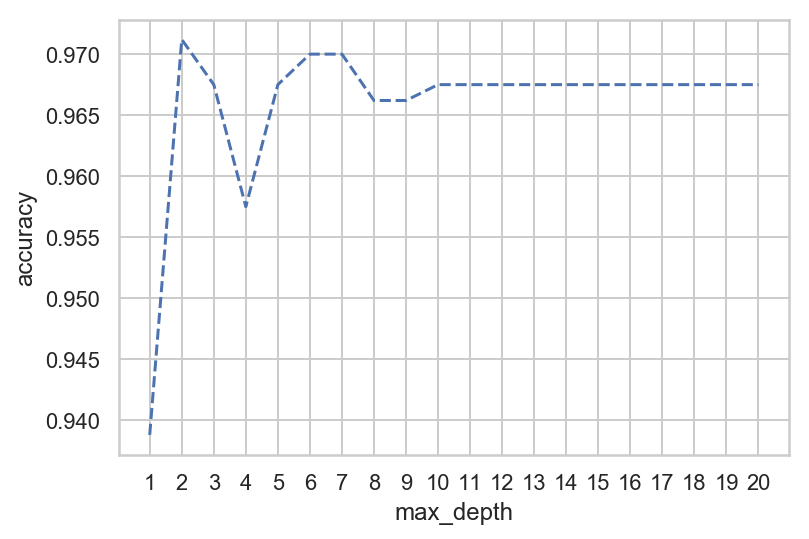

In [64]:
xx = ["{}".format(i) for i in range(1, 21)]
plt.plot(xx, cvs, "--")
ax.set_ylim([0.96, 1])
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

max_depth가 얼마일 때 최대의 accuracy를 갖는지 확인해보자.

In [65]:
cvs.index(max(cvs)) + 1, max(cvs)

(2, 0.9712)

즉, **max_depth가 2인 경우 0.9712의 정확성을 보인다.**

max_depth가 2일 때 `classification report`와 `confusion matrix`로도 확인해보자.

In [66]:
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    model = DecisionTreeClassifier(max_depth=2,random_state=2).fit(X_train, y_train)

마지막 모델의 `confusion_matrix`와 `classification_report`는 다음과 같다.

In [67]:
confusion_matrix(y_test, model.predict(X_test))

array([[145,   2],
       [  0,  13]], dtype=int64)

In [68]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99       147
        True       0.87      1.00      0.93        13

   micro avg       0.99      0.99      0.99       160
   macro avg       0.93      0.99      0.96       160
weighted avg       0.99      0.99      0.99       160



꽤 좋은 모델이군!